In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import json
import os
import shutil
import numpy as np
from glob import glob

In [ ]:
!pip -q install kaggle
!mkdir /root/.kaggle

token = {"username":"raqhea","key":"6945807e6399316dfb405a62642dcd12"}
with open('/root/.kaggle/kaggle.json', 'w') as f:
  json.dump(token, f)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# download the dataset
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 539M/544M [00:05<00:00, 113MB/s]
100% 544M/544M [00:05<00:00, 98.6MB/s]
 96% 261M/271M [00:03<00:00, 97.3MB/s]
100% 271M/271M [00:03<00:00, 79.6MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 90.1MB/s]


In [ ]:
!unzip test.zip
!unzip train.zip

In [ ]:
# total number of train images
print('Total train dataset length:',len(glob('train/*')))
print('Total test dataset length:', len(glob('test/*')))

Total train dataset length: 25000
Total test dataset length: 12500


In [ ]:
# Let's look at class distribution
print('We have 2 classes: Dog, Cat')
print('There are %d Dog images'% len(glob('train/dog*')))
print('There are %d Cat images'% len(glob('train/cat*')))

We have 2 classes: Dog, Cat
There are 12500 Dog images
There are 12500 Cat images


In [ ]:
# split the categories by creating different directories for classes
file_list = os.listdir('train')
os.mkdir('train/Cat')
os.mkdir('train/Dog')


# I'll split the data in order to create balanced splits 
for f_name in file_list:
  f_path = os.path.join('train', f_name)
  label = f_name[:3]
  if label == 'cat':
    shutil.move(f_path, 'train/Cat')
  elif label == 'dog':
    shutil.move(f_path, 'train/Dog') 

In [ ]:
# now we can create train/validation/test splits
base_path = 'dataset'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

paths = [test_path, val_path, train_path]
# create a directories for splits
os.mkdir(base_path)
os.mkdir(train_path)
os.mkdir(val_path)
os.mkdir(test_path)
# create categorical directories for splits
for path in paths:
  cat_path = os.path.join(path, 'Cat')
  dog_path = os.path.join(path, 'Dog')
  os.mkdir(cat_path)
  os.mkdir(dog_path)
# move the files according to categories for every single split
# 20% of the training data will be used as test set while other 20% of training data will be used as validation set 
test_ratio = 0.2
val_ratio = 0.2
train_ratio = 1 - test_ratio - val_ratio
# get the total number of files for each split
total = len(file_list)
N_train = int(total*train_ratio)
N_test = int(total*test_ratio)
N_validation = int(total*val_ratio)
# files of different categories
cat_files = glob('train/Cat/*')
dog_files = glob('train/Dog/*')
# get the balanced splits
test_files = cat_files[:N_test//2] + dog_files[:N_test//2]
val_files = cat_files[N_test//2: (N_test + N_validation)//2] + dog_files[N_test//2: (N_test + N_validation)//2]
train_files = cat_files[-N_train//2:] + dog_files[-N_train//2:] # Equivalent with "file_list[(N_test + N_validation)//2:]"
# finally we can move them to their own directories
for file_list, path in zip([test_files, val_files, train_files], paths):
  for f_path in file_list:
    label = f_path[10:13] # example file path: train/Dog/dog.1234.jpg
    if label == 'cat':
      shutil.move(f_path, os.path.join(path, 'Cat'))
    elif label == 'dog':
      shutil.move(f_path, os.path.join(path, 'Dog'))

In [ ]:
# sanity check
glob('dataset/train/Cat/*')
# we separated the data successfully

In [ ]:
# create image generators to create a dataset as Python generator 
BATCH_SIZE = 32
IMAGE_SIZE = [150,150]
SEED = 42

train_gen = ImageDataGenerator(rescale = 1./255,
                               horizontal_flip = True,
                               vertical_flip = True,
                               fill_mode = 'nearest',
                               shear_range = .15,
                               zoom_range = .15,
                               rotation_range = 45)
val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

# now create a flow from directory that generates data for us 
train_ds = train_gen.flow_from_directory(train_path,
                                         target_size = tuple(IMAGE_SIZE),
                                         class_mode = 'binary',
                                         batch_size = BATCH_SIZE,
                                         seed = SEED)
val_ds = val_gen.flow_from_directory(val_path,
                                        target_size = tuple(IMAGE_SIZE),
                                        class_mode = 'binary',
                                        batch_size = BATCH_SIZE,
                                        seed = SEED)
test_ds = test_gen.flow_from_directory(test_path,
                                       class_mode = 'binary',
                                       target_size = tuple(IMAGE_SIZE),
                                       batch_size = BATCH_SIZE)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# helper function to save the model with random name
def save_model(model):
  r = np.random.randint(0,10e+7)
  model_name = "model_%d.h5"%r
  if model_name in os.listdir():
    return save_model(model)
  model.save(model_name)
  return "Model saved as %s" % model_name

# create the model
model = models.Sequential([
  layers.Input(shape =  tuple(IMAGE_SIZE + [3])),
  layers.Conv2D(32, 3, activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(.35),
  layers.Dense(512, activation = 'relu'),
  layers.Dense(1, activation = 'sigmoid')
])
model.compile(optimizer = optimizers.RMSprop(),
              loss = losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

print(model.summary())
# train the model
EPOCHS = 30
r = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 100,
              validation_steps = 50, epochs = EPOCHS)


model.save('small_convnet_catsvsdogs.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

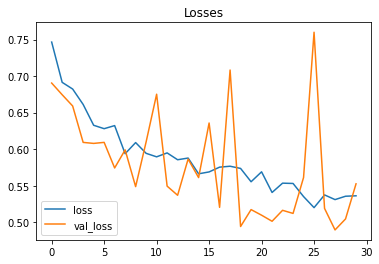

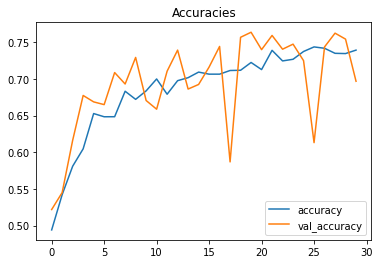

In [ ]:
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.title('Accuracies')
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
# Create another model with using convolutional base of pre-trained VGG16 architecture
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = tuple(IMAGE_SIZE + [3]))
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
# extract the features from convolutional base (without data augmentation)
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20
def extract_features(directory, num_samples):
  # output from convolutional base has shape 4x4x512
  # so if we want to extract num_samples feature, the output should be in the shape of num_samplesx4x4x512
  features = np.zeros(shape=(num_samples, 4, 4, 512))
  labels = np.zeros(shape=(num_samples))
  dataset = datagen.flow_from_directory(directory,
                                        batch_size = batch_size,
                                        target_size = tuple(IMAGE_SIZE),
                                        class_mode = 'binary')
  i = 0
  for inputs_batch, labels_batch in dataset:
    batch_features = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = batch_features
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if (i * batch_size) >= num_samples:
      break
  return features, labels

In [ ]:
train_features, train_labels = extract_features(train_path, 2000)
val_features, val_labels = extract_features(val_path, 1000)
test_features, test_labels = extract_features(test_path, 1000)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# now we must flatten these in order to feed our Dense layers.
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
val_features = np.reshape(val_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
train_features[0].shape

(8192,)

In [ ]:
# Finally we can build our model
model = models.Sequential([
  layers.Input(shape = train_features[0].shape),
  layers.Dense(256, activation = 'relu'),
  layers.Dropout(.5),
  layers.Dense(1, activation = 'sigmoid')
])
model.compile(optimizer = optimizers.RMSprop(2e-5),
              loss = losses.BinaryCrossentropy(),
              metrics = ['acc'])

r = model.fit(train_features, train_labels,
              validation_data = (val_features, val_labels),
              epochs = 30,
              batch_size = 20)

model.save('tl_feature_extraction_convnet.h5')

Epoch 1/30
100/100 [==============================] - 0s 5ms/step - loss: 0.5746 - acc: 0.6975 - val_loss: 0.4420 - val_acc: 0.8440
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4328 - acc: 0.8035 - val_loss: 0.3772 - val_acc: 0.8350
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3712 - acc: 0.8435 - val_loss: 0.3373 - val_acc: 0.8580
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3225 - acc: 0.8665 - val_loss: 0.3076 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3002 - acc: 0.8760 - val_loss: 0.2914 - val_acc: 0.8810
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2741 - acc: 0.8870 - val_loss: 0.2803 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2630 - acc: 0.8985 - val_loss: 0.2723 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

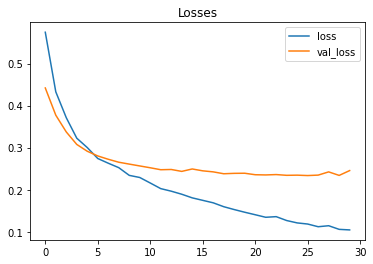

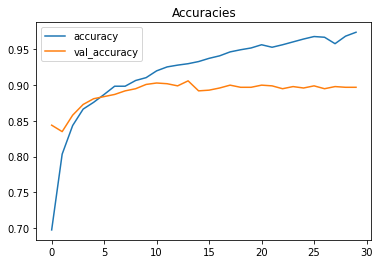

In [ ]:
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.title('Accuracies')
plt.plot(r.history['acc'], label = 'accuracy')
plt.plot(r.history['val_acc'], label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
# evaluate the test data
model.evaluate(test_features, test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 0.2671 - acc: 0.9010


[0.26712000370025635, 0.9010000228881836]

In [ ]:
# create augmented dataset to use another approach

train_gen = ImageDataGenerator(rescale = 1./255,
                               horizontal_flip = True,
                               vertical_flip = True,
                               fill_mode = 'nearest',
                               shear_range = .15,
                               zoom_range = .15,
                               rotation_range = 45)
val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

# now create a flow from directory that generates data for us 
train_ds = train_gen.flow_from_directory(train_path,
                                         target_size = tuple(IMAGE_SIZE),
                                         class_mode = 'binary',
                                         batch_size = BATCH_SIZE,
                                         seed = SEED)
val_ds = val_gen.flow_from_directory(val_path,
                                        target_size = tuple(IMAGE_SIZE),
                                        class_mode = 'binary',
                                        batch_size = BATCH_SIZE,
                                        seed = SEED)
test_ds = test_gen.flow_from_directory(test_path,
                                       class_mode = 'binary',
                                       target_size = tuple(IMAGE_SIZE),
                                       batch_size = BATCH_SIZE)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Now freeze the training state of convolutional base and build a model again.
# this allow us to apply data augmentation on the data.

# freeze the conv_base's training state
conv_base.trainable = False

model = models.Sequential([
  conv_base,
  layers.Flatten(),
  layers.Dense(256, activation = 'relu'),
  layers.Dropout(.25),
  layers.Dense(1, activation = 'sigmoid')
])
print(model.summary())
# as we can see form model summary, all the parameters of vgg16 block are in "non-trainable params". 
# We freezed the state of the model because we don't want to lose the representations learned before. 
# The weights are randomly initialized on training phase, so this may lead us to information loss

# compile the model
model.compile(optimizer = optimizers.RMSprop(2e-5),
              loss = losses.BinaryCrossentropy(),
              metrics = ['acc'])

r = model.fit(train_ds,
              steps_per_epoch = 100,
              validation_data = val_ds,
              validation_steps = 50,
              batch_size = BATCH_SIZE,
              epochs = 30)

model.save('tl_convbase_convnet.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/30
100/100 [==============================] - 30s 298ms/step - loss: 0.6417 - acc: 0.62

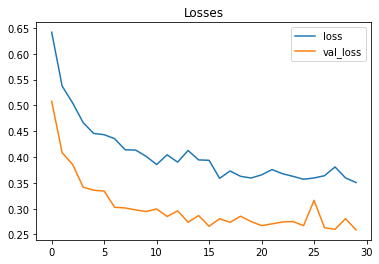

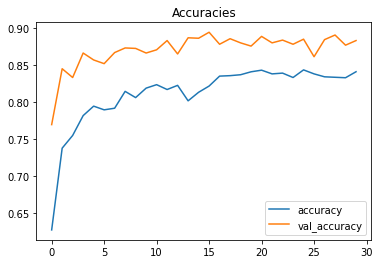

In [ ]:
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.title('Accuracies')
plt.plot(r.history['acc'], label = 'accuracy')
plt.plot(r.history['val_acc'], label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
# we can also fine-tune few layers from pre-trained network. In this example, I'll fine-tune block5_conv1
# the important note would be fine-tuning a layer that is between pre-trained layers 
# is better approach since we can lose the pre-trained layer's learned representations

# in order to make sure we only fine-tune 5th convolutional block, I'll unfreeze the model state and then only freeze the layers I want to tune.
conv_base.trainable = True
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    layer.trainable = True
  else:
    layer.trainable = False

print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# now I'll tune these layers with RMSprop while using very low learning rate. 
# I'm using very low learning rate to make sure tuning phase have minimal impact (minimal improvement) on model's current state. 
model = models.Sequential([
  conv_base,
  layers.Flatten(),
  layers.Dense(256, activation = 'relu'),
  layers.Dropout(.25),
  layers.Dense(1, activation = 'sigmoid')
])
model.compile(optimizer = optimizers.RMSprop(1e-5),
              loss = losses.BinaryCrossentropy(),
              metrics = ['acc'])


r = model.fit(train_ds, validation_data = val_ds, epochs = 30, validation_steps = 50, steps_per_epoch = 100)

model.save('tl_finetune_convnets.h5')

Epoch 1/30
100/100 [==============================] - 29s 293ms/step - loss: 0.6549 - acc: 0.6069 - val_loss: 0.4656 - val_acc: 0.8219
Epoch 2/30
100/100 [==============================] - 29s 289ms/step - loss: 0.5239 - acc: 0.7368 - val_loss: 0.3853 - val_acc: 0.8356
Epoch 3/30
100/100 [==============================] - 29s 291ms/step - loss: 0.4550 - acc: 0.7872 - val_loss: 0.3188 - val_acc: 0.8662
Epoch 4/30
100/100 [==============================] - 29s 292ms/step - loss: 0.4132 - acc: 0.8044 - val_loss: 0.2915 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 29s 289ms/step - loss: 0.3910 - acc: 0.8156 - val_loss: 0.2884 - val_acc: 0.8769
Epoch 6/30
100/100 [==============================] - 29s 289ms/step - loss: 0.3720 - acc: 0.8343 - val_loss: 0.2953 - val_acc: 0.8637
Epoch 7/30
100/100 [==============================] - 29s 289ms/step - loss: 0.3558 - acc: 0.8419 - val_loss: 0.2828 - val_acc: 0.8813
Epoch 8/30
100/100 [==============================] - 2

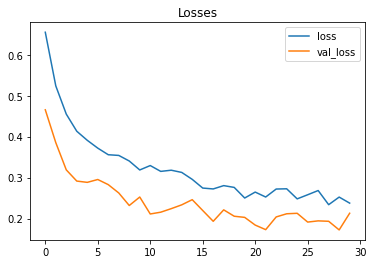

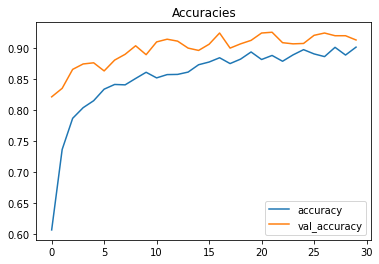

In [ ]:
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.title('Accuracies')
plt.plot(r.history['acc'], label = 'accuracy')
plt.plot(r.history['val_acc'], label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_ds)

157/157 [==============================] - 17s 110ms/step - loss: 0.2117 - acc: 0.9128


[0.21171553432941437, 0.9128000140190125]

In [ ]:
# Import all the models, then evaluate the test dataset
import pandas as pd
df = []
for model_name in ['small_convnet_catsvsdogs', 'tl_convbase_convnet', 'tl_feature_extraction_convnet', 'tl_finetune_convnets']:
  model = tf.keras.models.load_model(f"{model_name}.h5")
  if model_name == 'tl_feature_extraction_convnet':
    loss, accuracy = model.evaluate(test_features, test_labels)
  else:
    loss, accuracy = model.evaluate(test_ds)
  row = [model_name, loss, accuracy]
  df.append(row)
pd.DataFrame(df, columns = ['Model name', 'Loss', 'Accuracy']) 
# we can see fine-tuned model performed best on our problem. Since this may vary to problem at hand, trying different
# approaches is always better.

157/157 [==============================] - 16s 105ms/step - loss: 0.2117 - acc: 0.9128


,Model name,Loss,Accuracy
0,small_convnet_catsvsdogs,0.569930,0.6948
1,tl_convbase_convnet,0.281179,0.8796
2,tl_feature_extraction_convnet,0.267120,0.9010
3,tl_finetune_convnets,0.211716,0.9128


In [ ]:
# visualising the outputs of convolutional layers
# there are 3 approaches for visualising convnets. 
# first one is visualising the activation (output) of intermediate layers to see applied transformations
# second one is visualising convnet filters to understand precisely what pattern each filter in a convnet receptive to
# third one is visualising heatmaps of class activation in an image to understand which parts of the image is 
# responsible for class labeling.

# 1) visualise the activation of intermediate layers of small_convnet
# load the model
model = tf.keras.models.load_model('small_convnet_catsvsdogs.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

(1, 150, 150, 3)


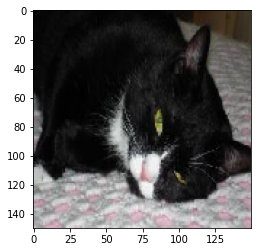

In [ ]:
# get a sample image
random_cat = np.random.choice(glob('dataset/train/Cat/*'))

from tensorflow.keras.preprocessing import image
img = image.load_img(random_cat, target_size = tuple(IMAGE_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.0 # normalize the data
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# extract the layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.inputs, outputs = layer_outputs)
# this model will output the layer's activations. We get the outputs from first 7 layer 
# (the layers from beginning to the flatten layer)
activations = activation_model(img_tensor) # returns layer outputs as a list of arrays
print(type(activations), len(activations))

<class 'list'> 8


activation shape: (1, 148, 148, 32)


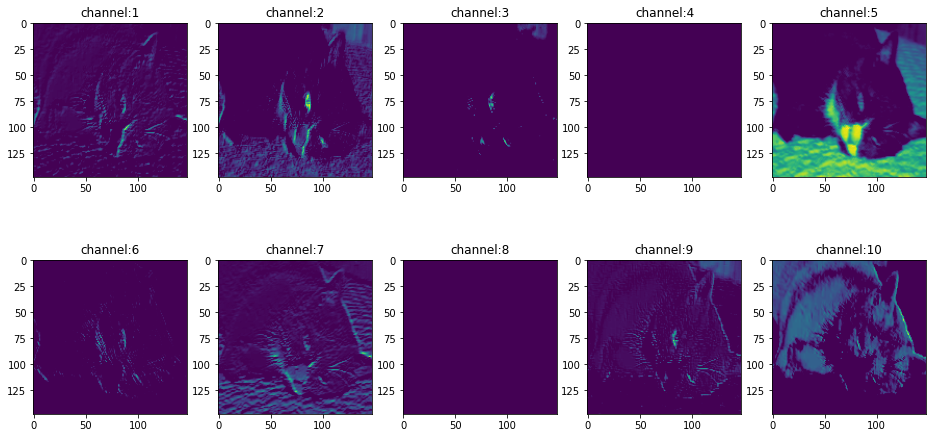

In [ ]:
# first layer activation (conv2d layer)
first_activation = activations[0]
print("activation shape:",first_activation.shape) # it has 32 channels
# show the first ten channels of the activation of the first layer of the original model
plt.figure(figsize = (16,8))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.title(f"channel:{i+1}")
  plt.imshow(first_activation[0, :, :, i])

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


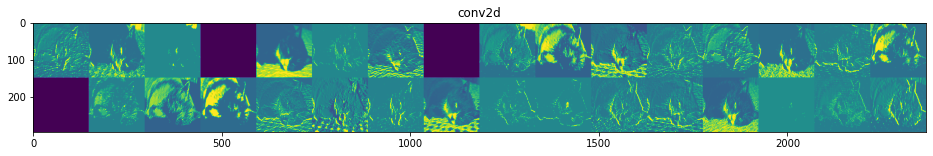

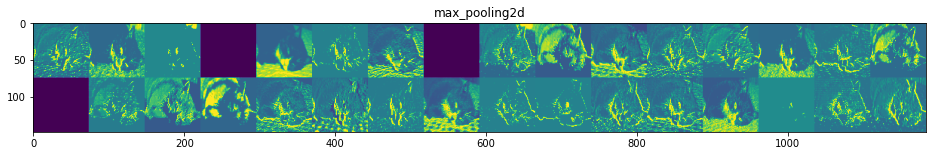

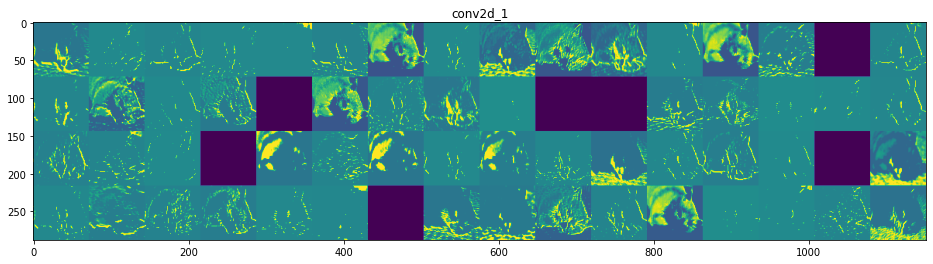

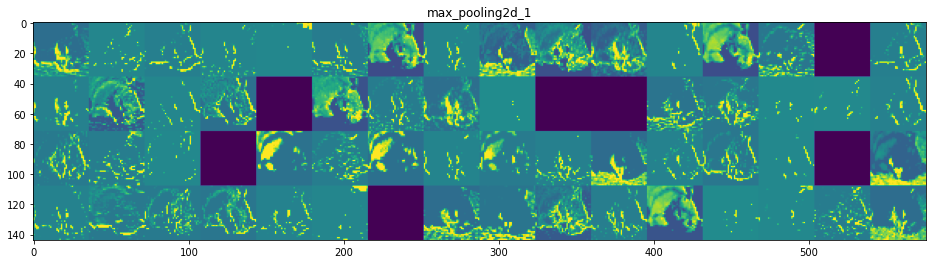

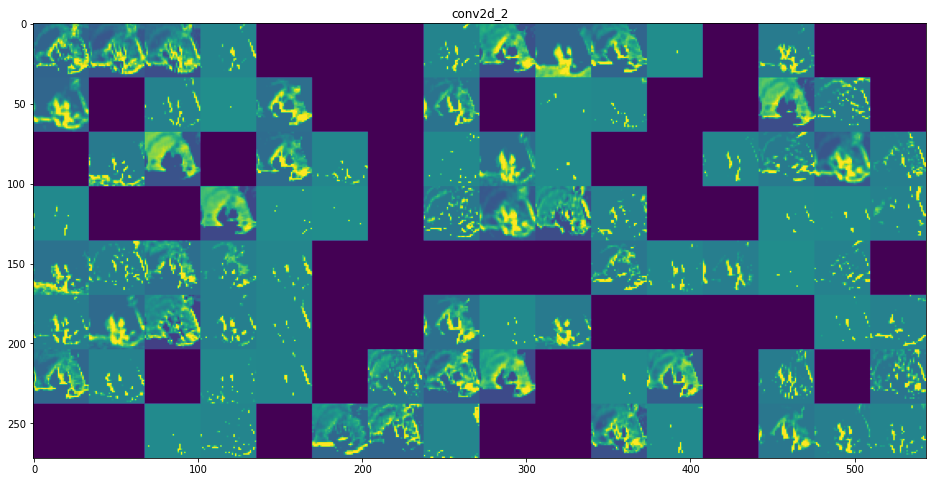

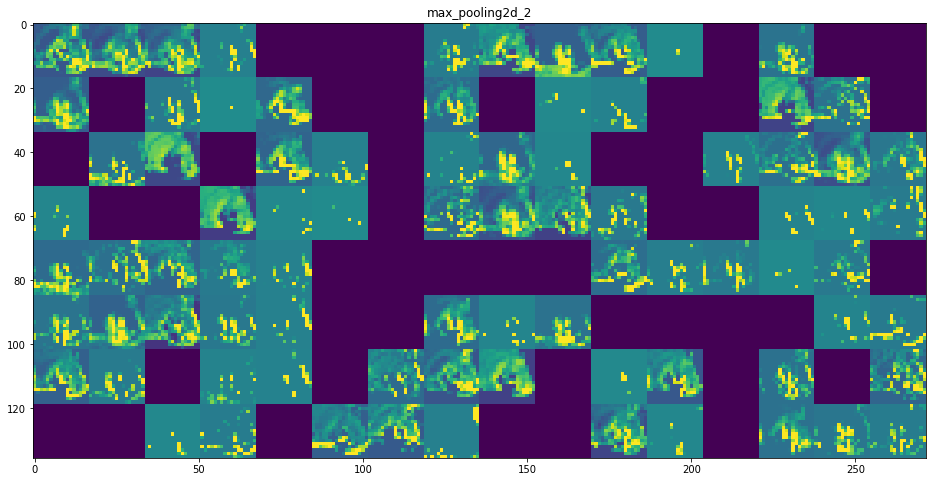

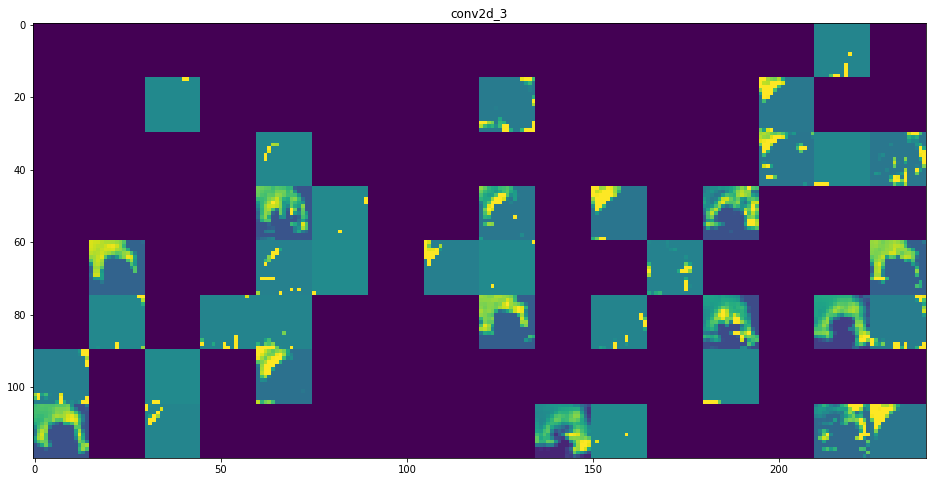

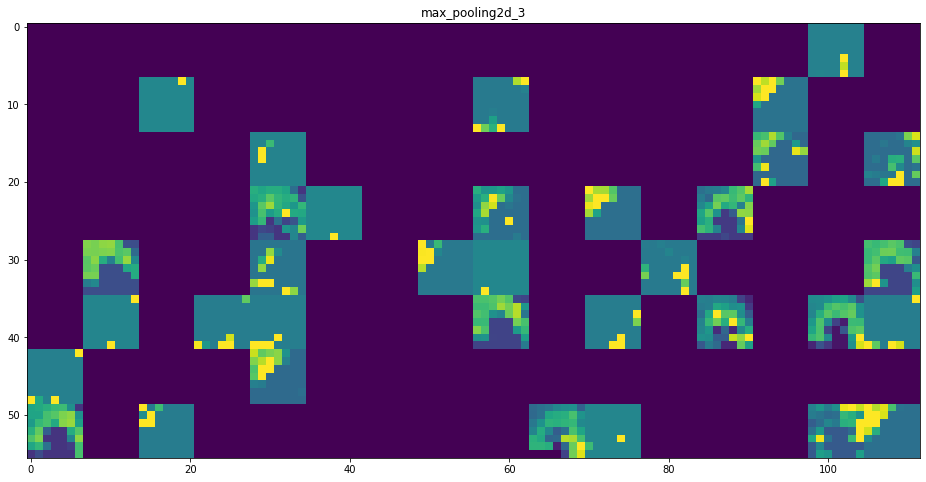

In [ ]:
# Now let's plot every layers output
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1] # number of features in the feature map

  size = layer_activation.shape[1] # feature map has shape (1,size,size,n_features)

  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image = channel_image.numpy()
      channel_image -= channel_image.mean() # standardization
      channel_image /= channel_image.std() # standardization
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size: (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

Predicted: [[('n02123597', 'Siamese_cat', 0.9187287), ('n02441942', 'weasel', 0.02136693), ('n02127052', 'lynx', 0.018582508)]]


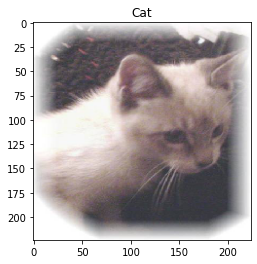

In [ ]:
# method 2: visualising heatmaps of class activations
# this will show us which part of image led to convnet to classify the image
# to find out which filter receptive to what, I'll apply gradient ascent by simply 
# this technique often called Class Activation Map (CAM) visualization

# get a sample image
random_class = np.random.choice(['Dog','Cat'])
random_img = np.random.choice(glob(f'dataset/train/{random_class}/*'))

# I'll use VGG16 model again, this time we should preprocess the data with same procedures to make it understandable for VGG16 pre-trained model
from keras.applications.vgg16 import preprocess_input, decode_predictions
model = VGG16(weights = 'imagenet')

img = image.load_img(random_img, target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

# now run pretrained network on the image and get the predictions
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3))


plt.title(random_class)
plt.imshow(img)
plt.show()

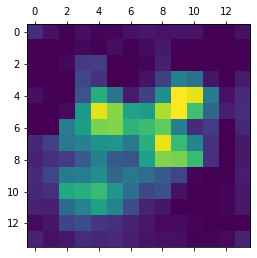

In [ ]:
import keras.backend as K

# get the prediction with maximum probability
max_prob_label = model.output[:, np.argmax(preds)]
# get the last convolution layer in the VGG16
last_conv_layer = model.get_layer('block5_conv3') 

grads = K.gradients(max_prob_label, last_conv_layer.output)[0] # gradient of the class with regard to output feature map of block5_conv3 layer

pooled_grads = K.mean(grads, axis = (0, 1, 2)) # vector of shape (512,) where each entry is the mean intensity of the gradient over specific feature-map channel

iterate = K.function([model.input], 
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis = -1)


# normalize the data
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

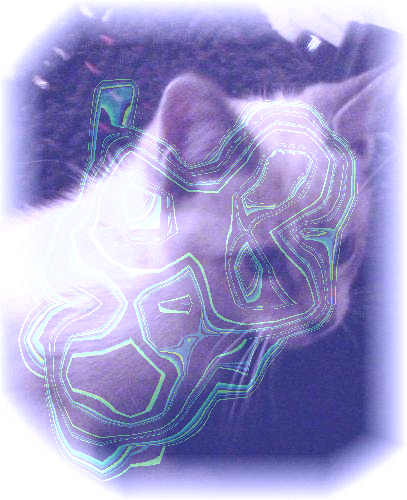

True

In [ ]:
# Now we'll need OpenCV to superimpose the heatmap and image
import cv2

img = cv2.imread(random_img)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap) # convert the heatmap to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # applies the heatmap to the original image
superimposed_img = heatmap * 0.4 + img

from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)

cv2.imwrite('superimposedimg.jpg', superimposed_img)